# 1 初始化

## 1.1 导入包

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from tqdm import tqdm
import logging

log_fmt = "[%(asctime)s] %(levelname)s in %(module)s: %(message)s"
logging.basicConfig(format=log_fmt, level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

## 1.2 超参数定义

In [4]:
base_path = '/home/zengrui/datasets/190829_Kanshan_zjfx'

## 1.3 函数定义

In [5]:
def extract_day(s):
    return s.apply(lambda x: int(x.split('-')[0][1:]))


def extract_hour(s):
    return s.apply(lambda x: int(x.split('-')[1][1:]))

# 2 加载、处理数据

## 2.1 加载邀请回答数据

In [31]:
train = pd.read_csv(f'{base_path}/invite_info_0926.txt', sep='\t', header=None)
train.columns = ['qid', 'uid', 'dt', 'label']
logging.info("invite %s", train.shape)

test = pd.read_csv(f'{base_path}/invite_info_evaluate_1_0926.txt', sep='\t', header=None)
test.columns = ['qid', 'uid', 'dt']
logging.info("test %s", test.shape)

sub = test.copy()

sub_size = len(sub)

train['day'] = extract_day(train['dt'])
train['hour'] = extract_hour(train['dt'])

test['day'] = extract_day(test['dt'])
test['hour'] = extract_hour(test['dt'])

del train['dt'], test['dt']

[2019-12-06 19:22:45,811] INFO in <ipython-input-31-7a2c6478cb9e>: invite (9489162, 4)
[2019-12-06 19:22:46,902] INFO in <ipython-input-31-7a2c6478cb9e>: test (1141683, 3)


## 2.2 加载问题

丢弃了**问题info**的字词编码。

In [32]:
ques = pd.read_csv(f'{base_path}/question_info_0926.txt', header=None, sep='\t')
ques.columns = ['qid', 'q_dt', 'title_t1', 'title_t2', 'desc_t1', 'desc_t2', 'topic']
del ques['title_t1'], ques['title_t2'], ques['desc_t1'], ques['desc_t2']
logging.info("ques %s", ques.shape)

ques['q_day'] = extract_day(ques['q_dt'])
ques['q_hour'] = extract_hour(ques['q_dt'])
del ques['q_dt']

[2019-12-06 19:23:16,513] INFO in <ipython-input-32-958902b92fc5>: ques (1829900, 3)


## 2.3 加载回答

丢弃了**回答info**的字词编码，并与**问题info**合并。

In [33]:
ans = pd.read_csv(f'{base_path}/answer_info_0926.txt', header=None, sep='\t')
ans.columns = ['aid', 'qid', 'uid', 'ans_dt', 'ans_t1', 'ans_t2', 'is_good', 'is_rec', 'is_dest', 'has_img',
               'has_video', 'word_count', 'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
               'reci_xxx', 'reci_no_help', 'reci_dis']
del ans['ans_t1'], ans['ans_t2']
logging.info("ans %s", ans.shape)

ans['a_day'] = extract_day(ans['ans_dt'])
ans['a_hour'] = extract_hour(ans['ans_dt'])
del ans['ans_dt']

ans = pd.merge(ans, ques, on='qid')
del ques

[2019-12-06 19:24:25,461] INFO in <ipython-input-33-935311f5f359>: ans (4513735, 18)


## 2.4 处理时间数据

回答距提问的天数。

In [34]:
ans['diff_qa_days'] = ans['a_day'] - ans['q_day']

时间窗口划分。

In [35]:
train_start = 3838
train_end = 3867

val_start = 3868
val_end = 3874

label_end = 3867
label_start = label_end - 6

train_label_feature_end = label_end - 7
train_label_feature_start = train_label_feature_end - 22

train_ans_feature_end = label_end - 7
train_ans_feature_start = train_ans_feature_end - 50

val_label_feature_end = val_start - 1
val_label_feature_start = val_label_feature_end - 22

val_ans_feature_end = val_start - 1
val_ans_feature_start = val_ans_feature_end - 50

train_label_feature = train[(train['day'] >= train_label_feature_start) & (train['day'] <= train_label_feature_end)]
logging.info("train_label_feature %s", train_label_feature.shape)

val_label_feature = train[(train['day'] >= val_label_feature_start) & (train['day'] <= val_label_feature_end)]
logging.info("val_label_feature %s", val_label_feature.shape)

train_label = train[(train['day'] > train_label_feature_end)]

logging.info("train feature start %s end %s, label start %s end %s", train_label_feature['day'].min(),
             train_label_feature['day'].max(), train_label['day'].min(), train_label['day'].max())

logging.info("test feature start %s end %s, label start %s end %s", val_label_feature['day'].min(),
             val_label_feature['day'].max(), test['day'].min(), test['day'].max())

[2019-12-06 19:24:40,394] INFO in <ipython-input-35-5c7aac178bca>: train_label_feature (6895493, 5)
[2019-12-06 19:24:41,033] INFO in <ipython-input-35-5c7aac178bca>: val_label_feature (7583553, 5)
[2019-12-06 19:24:41,608] INFO in <ipython-input-35-5c7aac178bca>: train feature start 3838 end 3860, label start 3861 end 3867
[2019-12-06 19:24:41,637] INFO in <ipython-input-35-5c7aac178bca>: test feature start 3845 end 3867, label start 3868 end 3874


```python
print(train_label_feature_start, train_label_feature_end)
print(train_ans_feature_start, train_ans_feature_end)
print(val_label_feature_start, val_label_feature_end)
print(val_ans_feature_start, val_ans_feature_end)
```
```text
3838 3860
3810 3860
3845 3867
3817 3867
```

确定ans的时间范围。

In [36]:
train_ans_feature = ans[(ans['a_day'] >= train_ans_feature_start) & (ans['a_day'] <= train_ans_feature_end)]

val_ans_feature = ans[(ans['a_day'] >= val_ans_feature_start) & (ans['a_day'] <= val_ans_feature_end)]

logging.info("train ans feature %s, start %s end %s", train_ans_feature.shape, train_ans_feature['a_day'].min(),
             train_ans_feature['a_day'].max())

logging.info("val ans feature %s, start %s end %s", val_ans_feature.shape, val_ans_feature['a_day'].min(),
             val_ans_feature['a_day'].max())

fea_cols = ['is_good', 'is_rec', 'is_dest', 'has_img', 'has_video', 'word_count',
            'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
            'reci_xxx', 'reci_no_help', 'reci_dis', 'diff_qa_days']

[2019-12-06 19:24:45,880] INFO in <ipython-input-36-502ad99fdbbb>: train ans feature (3700178, 23), start 3810 end 3860
[2019-12-06 19:24:45,890] INFO in <ipython-input-36-502ad99fdbbb>: val ans feature (3992334, 23), start 3817 end 3867


## 2.5 特征提取

测试学习。

In [6]:
df = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                      'foo', 'bar', 'foo', 'foo'],
                   'B' : ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                   'C' : np.random.randn(8),
                   'D' : np.random.randn(8)})
df

,A,B,C,D
0,foo,one,-0.210167,0.548738
1,bar,one,0.853955,-1.299085
2,foo,two,0.854437,-0.834424
3,bar,three,0.190360,-2.248480
4,foo,two,0.703505,-0.893611
5,bar,two,-0.547142,-0.271686
6,foo,one,-0.574980,0.907734
7,foo,three,-0.484821,-0.159479


In [16]:
[x for x in df.groupby('A')['D']]

[('bar', 1   -1.299085
  3   -2.248480
  5   -0.271686
  Name: D, dtype: float64), ('foo', 0    0.548738
  2   -0.834424
  4   -0.893611
  6    0.907734
  7   -0.159479
  Name: D, dtype: float64)]

正式开始。

In [37]:
def extract_feature1(target, label_feature, ans_feature):
    # 问题特征
    t1 = label_feature.groupby('qid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['qid', 'q_inv_mean', 'q_inv_sum', 'q_inv_std', 'q_inv_count', 
                  'q_inv_max', 'q_inv_min']
    target = pd.merge(target, t1, on='qid', how='left')

    # 用户特征
    t1 = label_feature.groupby('uid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['uid', 'u_inv_mean', 'u_inv_sum', 'u_inv_std', 'u_inv_count', 
                  'u_inv_max', 'u_inv_min']
    target = pd.merge(target, t1, on='uid', how='left')
    #
    # train_size = len(train)
    # data = pd.concat((train, test), sort=True)

    # 回答部分特征

    t1 = ans_feature.groupby('qid')['aid'].count().reset_index()
    t1.columns = ['qid', 'q_ans_count']
    target = pd.merge(target, t1, on='qid', how='left')

    t1 = ans_feature.groupby('uid')['aid'].count().reset_index()
    t1.columns = ['uid', 'u_ans_count']
    target = pd.merge(target, t1, on='uid', how='left')

    for col in fea_cols:
        t1 = ans_feature.groupby('uid')[col].agg(['sum', 'max', 'mean', 
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['uid', f'u_{col}_sum', f'u_{col}_max', f'u_{col}_mean',
                      f'u_{col}_std', f'u_{col}_count', f'u_{col}_min']
        target = pd.merge(target, t1, on='uid', how='left')

        t1 = ans_feature.groupby('qid')[col].agg(['sum', 'max', 'mean',
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['qid', f'q_{col}_sum', f'q_{col}_max', f'q_{col}_mean',
                      f'q_{col}_std', f'q_{col}_count', f'q_{col}_min']
        target = pd.merge(target, t1, on='qid', how='left')
        logging.info("extract %s", col)
    return target


train_label = extract_feature1(train_label, train_label_feature, train_ans_feature)
test = extract_feature1(test, val_label_feature, val_ans_feature)

[2019-12-06 19:25:26,396] INFO in <ipython-input-37-0304f9fa763e>: extract is_good
[2019-12-06 19:25:39,810] INFO in <ipython-input-37-0304f9fa763e>: extract is_rec
[2019-12-06 19:25:53,376] INFO in <ipython-input-37-0304f9fa763e>: extract is_dest
[2019-12-06 19:26:07,134] INFO in <ipython-input-37-0304f9fa763e>: extract has_img
[2019-12-06 19:26:21,375] INFO in <ipython-input-37-0304f9fa763e>: extract has_video
[2019-12-06 19:26:35,872] INFO in <ipython-input-37-0304f9fa763e>: extract word_count
[2019-12-06 19:26:50,706] INFO in <ipython-input-37-0304f9fa763e>: extract reci_cheer
[2019-12-06 19:27:05,760] INFO in <ipython-input-37-0304f9fa763e>: extract reci_uncheer
[2019-12-06 19:27:21,536] INFO in <ipython-input-37-0304f9fa763e>: extract reci_comment
[2019-12-06 19:27:37,347] INFO in <ipython-input-37-0304f9fa763e>: extract reci_mark
[2019-12-06 19:27:53,245] INFO in <ipython-input-37-0304f9fa763e>: extract reci_tks
[2019-12-06 19:28:09,886] INFO in <ipython-input-37-0304f9fa763e>: 

快存

In [38]:
with open(f'{base_path}/temp/train_label.txt', 'wb') as f:
    pickle.dump(train_label, f)

特征提取结束。

In [39]:
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)
assert len(test) == sub_size

[2019-12-06 19:33:02,359] INFO in <ipython-input-39-6bad7a600272>: train shape (2593669, 199), test shape (1141683, 198)


## 2.6 加载用户

In [40]:
user = pd.read_csv(f'{base_path}/member_info_0926.txt', header=None, sep='\t')
user.columns = ['uid', 'gender', 'creat_keyword', 'level', 'hot', 'reg_type', 'reg_plat', 'freq', 'uf_b1', 'uf_b2',
                'uf_b3', 'uf_b4', 'uf_b5', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5', 'score', 'follow_topic',
                'inter_topic']
del user['follow_topic'], user['inter_topic']
logging.info("user %s", user.shape)

unq = user.nunique()
logging.info("user unq %s", unq)

for x in unq[unq == 1].index:
    del user[x]
    logging.info('del unq==1 %s', x)

t = user.dtypes
cats = [x for x in t[t == 'object'].index if x not in ['follow_topic', 'inter_topic', 'uid']]
logging.info("user cat %s", cats)

for d in cats:
    lb = LabelEncoder()
    user[d] = lb.fit_transform(user[d])
    logging.info('encode %s', d)

q_lb = LabelEncoder()
q_lb.fit(list(train_label['qid'].astype(str).values) + list(test['qid'].astype(str).values))
train_label['qid_enc'] = q_lb.transform(train_label['qid'])
test['qid_enc'] = q_lb.transform(test['qid'])

u_lb = LabelEncoder()
u_lb.fit(user['uid'])
train_label['uid_enc'] = u_lb.transform(train_label['uid'])
test['uid_enc'] = u_lb.transform(test['uid'])

[2019-12-06 19:33:11,597] INFO in <ipython-input-40-f4f8e8f0ac9b>: user (1931654, 19)
[2019-12-06 19:33:14,207] INFO in <ipython-input-40-f4f8e8f0ac9b>: user unq uid              1931654
gender                 3
creat_keyword          1
level                  1
hot                    1
reg_type               1
reg_plat               1
freq                   5
uf_b1                  2
uf_b2                  2
uf_b3                  2
uf_b4                  2
uf_b5                  2
uf_c1               2561
uf_c2                291
uf_c3                428
uf_c4               1556
uf_c5                  2
score                732
dtype: int64
[2019-12-06 19:33:14,231] INFO in <ipython-input-40-f4f8e8f0ac9b>: del unq==1 creat_keyword
[2019-12-06 19:33:14,236] INFO in <ipython-input-40-f4f8e8f0ac9b>: del unq==1 level
[2019-12-06 19:33:14,237] INFO in <ipython-input-40-f4f8e8f0ac9b>: del unq==1 hot
[2019-12-06 19:33:14,348] INFO in <ipython-input-40-f4f8e8f0ac9b>: del unq==1 reg_type
[2019

merge user

In [41]:
train_label = pd.merge(train_label, user, on='uid', how='left')
test = pd.merge(test, user, on='uid', how='left')
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)

[2019-12-06 19:33:48,480] INFO in <ipython-input-41-a0af6fdcbd8e>: train shape (2593669, 214), test shape (1141683, 213)


及时清理内存。

In [43]:
del ans, train_label_feature, train_ans_feature, val_label_feature, val_ans_feature

In [59]:
data = pd.concat((train_label, test), axis=0, sort=True)
len_train_label = len(train_label)

# 暂存清理变量
with open(f'{base_path}/temp/train_label.txt', 'wb') as f:
    pickle.dump(train_label, f)
    del train_label
# with open(f'{base_path}/temp/test.txt', 'wb') as f:
#     pickle.dump(test, f)
#     del test

count编码。

In [60]:
count_fea = ['uid_enc', 'qid_enc', 'gender', 'freq', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5']
with tqdm(total=len(count_fea)) as pbar:
    for feat in count_fea:
        col_name = '{}_count'.format(feat)
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data.loc[data[col_name] < 2, feat] = -1
        data[feat] += 1
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data[col_name] = (data[col_name] - data[col_name].min()) / (data[col_name].max() - data[col_name].min())
        pbar.update(1)

100%|██████████| 9/9 [01:27<00:00,  9.72s/it]


## 2.7 处理数据

压缩数据。

In [61]:
t = data.dtypes
for x in t[t == 'int64'].index:
    data[x] = data[x].astype('int32')

for x in t[t == 'float64'].index:
    data[x] = data[x].astype('float32')

data['wk'] = data['day'] % 7

feature_cols = [x for x in data.columns if x not in ('label', 'uid', 'qid', 'dt', 'day')]

target编码。

In [62]:
logging.info("feature size %s", len(feature_cols))

# 恢复数据
with open(f'{base_path}/temp/train_label.txt', 'rb') as f:
    train_label = pickle.load(f)
    
X_train_all = data.iloc[:len_train_label][feature_cols]
y_train_all = data.iloc[:len_train_label]['label']

test = data.iloc[len_train_label:]
with open(f'{base_path}/temp/test.txt', 'wb') as f:
    pickle.dump(test, f)
    del test
    
assert len(data) - len_train_label == sub_size

[2019-12-06 19:54:04,000] INFO in <ipython-input-62-bc30c1df1da1>: feature size 220


# 3 训练树

## 3.1 预处理数据

In [63]:
logging.info("train shape %s, test shape %s", 
             data.iloc[:len_train_label].shape, 
             data.iloc[len_train_label:].shape)

with open(f'{base_path}/temp/data.txt', 'wb') as f:
    pickle.dump(data, f)
    del data


# 分层采样，交叉验证（切分5片）
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 但只用了其中一次切片
for index, (train_idx, val_idx) in enumerate(fold.split(X=X_train_all, y=y_train_all)):
    break

X_train, X_val, y_train, y_val = X_train_all.iloc[train_idx][feature_cols], X_train_all.iloc[val_idx][feature_cols], \
                                 y_train_all.iloc[train_idx], \
                                 y_train_all.iloc[val_idx]
# del X_train_all

[2019-12-06 19:54:36,395] INFO in <ipython-input-63-0b82ff0014ff>: train shape (2593669, 224), test shape (1141683, 224)


## 3.2 存取数据

存变量

In [64]:
import pickle

with open(f'{base_path}/temp/X_train.txt', 'wb') as f:
    pickle.dump(X_train, f)
with open(f'{base_path}/temp/y_train.txt', 'wb') as f:
    pickle.dump(y_train, f)
with open(f'{base_path}/temp/X_val.txt', 'wb') as f:
    pickle.dump(X_val, f)
with open(f'{base_path}/temp/y_val.txt', 'wb') as f:
    pickle.dump(y_val, f)
# with open(f'{base_path}/temp/test.txt', 'wb') as f:
#     pickle.dump(test, f)
with open(f'{base_path}/temp/sub.txt', 'wb') as f:
    pickle.dump(sub, f)
with open(f'{base_path}/temp/X_train_all.txt', 'wb') as f:
    pickle.dump(X_train_all, f)
with open(f'{base_path}/temp/y_train_all.txt', 'wb') as f:
    pickle.dump(y_train_all, f)
with open(f'{base_path}/temp/feature_cols.txt', 'wb') as f:
    pickle.dump(feature_cols, f)

取变量

In [4]:
import pickle

with open(f'{base_path}/temp/X_train.txt', 'rb') as f:
    X_train = pickle.load(f)
with open(f'{base_path}/temp/y_train.txt', 'rb') as f:
    y_train = pickle.load(f)
with open(f'{base_path}/temp/X_val.txt', 'rb') as f:
    X_val = pickle.load(f)
with open(f'{base_path}/temp/y_val.txt', 'rb') as f:
    y_val = pickle.load(f)
with open(f'{base_path}/temp/test.txt', 'rb') as f:
    test = pickle.load(f)
with open(f'{base_path}/temp/sub.txt', 'rb') as f:
    sub = pickle.load(f)
with open(f'{base_path}/temp/X_train_all.txt', 'rb') as f:
    X_train_all = pickle.load(f)
with open(f'{base_path}/temp/y_train_all.txt', 'rb') as f:
    y_train_all = pickle.load(f)
with open(f'{base_path}/temp/feature_cols.txt', 'rb') as f:
    feature_cols = pickle.load(f)

## 3.3 LGBM分类器训练

In [26]:
model_lgb = LGBMClassifier(n_estimators=2000, 
                           n_jobs=6, 
                           objective='binary', 
                           seed=1000, 
                           silent=True)
model_lgb.fit(X_train, y_train,
              eval_metric=['logloss', 'auc'],
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50)

[1]	valid_0's auc: 0.757149	valid_0's binary_logloss: 0.42656
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.775835	valid_0's binary_logloss: 0.41649
[3]	valid_0's auc: 0.781029	valid_0's binary_logloss: 0.408331
[4]	valid_0's auc: 0.784556	valid_0's binary_logloss: 0.401275
[5]	valid_0's auc: 0.786236	valid_0's binary_logloss: 0.395825
[6]	valid_0's auc: 0.787919	valid_0's binary_logloss: 0.391002
[7]	valid_0's auc: 0.790813	valid_0's binary_logloss: 0.386567
[8]	valid_0's auc: 0.793024	valid_0's binary_logloss: 0.382864
[9]	valid_0's auc: 0.795032	valid_0's binary_logloss: 0.379321
[10]	valid_0's auc: 0.796758	valid_0's binary_logloss: 0.376446
[11]	valid_0's auc: 0.797591	valid_0's binary_logloss: 0.373986
[12]	valid_0's auc: 0.798569	valid_0's binary_logloss: 0.371596
[13]	valid_0's auc: 0.799855	valid_0's binary_logloss: 0.369484
[14]	valid_0's auc: 0.800992	valid_0's binary_logloss: 0.367519
[15]	valid_0's auc: 0.802342	valid_0's binary_logloss:

[129]	valid_0's auc: 0.82835	valid_0's binary_logloss: 0.336506
[130]	valid_0's auc: 0.828414	valid_0's binary_logloss: 0.336456
[131]	valid_0's auc: 0.828437	valid_0's binary_logloss: 0.336433
[132]	valid_0's auc: 0.828478	valid_0's binary_logloss: 0.336404
[133]	valid_0's auc: 0.828498	valid_0's binary_logloss: 0.336386
[134]	valid_0's auc: 0.82854	valid_0's binary_logloss: 0.336346
[135]	valid_0's auc: 0.828584	valid_0's binary_logloss: 0.336309
[136]	valid_0's auc: 0.828632	valid_0's binary_logloss: 0.33627
[137]	valid_0's auc: 0.828664	valid_0's binary_logloss: 0.336244
[138]	valid_0's auc: 0.828722	valid_0's binary_logloss: 0.336192
[139]	valid_0's auc: 0.828753	valid_0's binary_logloss: 0.336164
[140]	valid_0's auc: 0.828772	valid_0's binary_logloss: 0.33615
[141]	valid_0's auc: 0.828826	valid_0's binary_logloss: 0.33611
[142]	valid_0's auc: 0.828873	valid_0's binary_logloss: 0.336075
[143]	valid_0's auc: 0.828923	valid_0's binary_logloss: 0.336037
[144]	valid_0's auc: 0.828953	

[256]	valid_0's auc: 0.831345	valid_0's binary_logloss: 0.334034
[257]	valid_0's auc: 0.831369	valid_0's binary_logloss: 0.33401
[258]	valid_0's auc: 0.831399	valid_0's binary_logloss: 0.333986
[259]	valid_0's auc: 0.831409	valid_0's binary_logloss: 0.333979
[260]	valid_0's auc: 0.831418	valid_0's binary_logloss: 0.333971
[261]	valid_0's auc: 0.831434	valid_0's binary_logloss: 0.333957
[262]	valid_0's auc: 0.831476	valid_0's binary_logloss: 0.333924
[263]	valid_0's auc: 0.831486	valid_0's binary_logloss: 0.333917
[264]	valid_0's auc: 0.831499	valid_0's binary_logloss: 0.333906
[265]	valid_0's auc: 0.831534	valid_0's binary_logloss: 0.333876
[266]	valid_0's auc: 0.831543	valid_0's binary_logloss: 0.333866
[267]	valid_0's auc: 0.831555	valid_0's binary_logloss: 0.333854
[268]	valid_0's auc: 0.831589	valid_0's binary_logloss: 0.333825
[269]	valid_0's auc: 0.831611	valid_0's binary_logloss: 0.333808
[270]	valid_0's auc: 0.831614	valid_0's binary_logloss: 0.333804
[271]	valid_0's auc: 0.831

[383]	valid_0's auc: 0.832953	valid_0's binary_logloss: 0.332697
[384]	valid_0's auc: 0.832954	valid_0's binary_logloss: 0.332696
[385]	valid_0's auc: 0.832967	valid_0's binary_logloss: 0.332686
[386]	valid_0's auc: 0.832984	valid_0's binary_logloss: 0.332673
[387]	valid_0's auc: 0.832984	valid_0's binary_logloss: 0.332674
[388]	valid_0's auc: 0.832986	valid_0's binary_logloss: 0.332672
[389]	valid_0's auc: 0.832989	valid_0's binary_logloss: 0.332668
[390]	valid_0's auc: 0.832988	valid_0's binary_logloss: 0.332669
[391]	valid_0's auc: 0.832992	valid_0's binary_logloss: 0.332666
[392]	valid_0's auc: 0.833004	valid_0's binary_logloss: 0.332656
[393]	valid_0's auc: 0.833005	valid_0's binary_logloss: 0.332654
[394]	valid_0's auc: 0.833023	valid_0's binary_logloss: 0.332643
[395]	valid_0's auc: 0.833042	valid_0's binary_logloss: 0.332627
[396]	valid_0's auc: 0.83305	valid_0's binary_logloss: 0.332619
[397]	valid_0's auc: 0.833051	valid_0's binary_logloss: 0.332617
[398]	valid_0's auc: 0.833

[510]	valid_0's auc: 0.833973	valid_0's binary_logloss: 0.331843
[511]	valid_0's auc: 0.833974	valid_0's binary_logloss: 0.331843
[512]	valid_0's auc: 0.833995	valid_0's binary_logloss: 0.331825
[513]	valid_0's auc: 0.834012	valid_0's binary_logloss: 0.331813
[514]	valid_0's auc: 0.834031	valid_0's binary_logloss: 0.331795
[515]	valid_0's auc: 0.834043	valid_0's binary_logloss: 0.331786
[516]	valid_0's auc: 0.834049	valid_0's binary_logloss: 0.331778
[517]	valid_0's auc: 0.834057	valid_0's binary_logloss: 0.331773
[518]	valid_0's auc: 0.83406	valid_0's binary_logloss: 0.33177
[519]	valid_0's auc: 0.834074	valid_0's binary_logloss: 0.331754
[520]	valid_0's auc: 0.834081	valid_0's binary_logloss: 0.331751
[521]	valid_0's auc: 0.834084	valid_0's binary_logloss: 0.331747
[522]	valid_0's auc: 0.834099	valid_0's binary_logloss: 0.331734
[523]	valid_0's auc: 0.834105	valid_0's binary_logloss: 0.33173
[524]	valid_0's auc: 0.834105	valid_0's binary_logloss: 0.331729
[525]	valid_0's auc: 0.83411

[637]	valid_0's auc: 0.834763	valid_0's binary_logloss: 0.331172
[638]	valid_0's auc: 0.834763	valid_0's binary_logloss: 0.331172
[639]	valid_0's auc: 0.834778	valid_0's binary_logloss: 0.331158
[640]	valid_0's auc: 0.834805	valid_0's binary_logloss: 0.331129
[641]	valid_0's auc: 0.834816	valid_0's binary_logloss: 0.331121
[642]	valid_0's auc: 0.834817	valid_0's binary_logloss: 0.33112
[643]	valid_0's auc: 0.834827	valid_0's binary_logloss: 0.331113
[644]	valid_0's auc: 0.83483	valid_0's binary_logloss: 0.331109
[645]	valid_0's auc: 0.834832	valid_0's binary_logloss: 0.331108
[646]	valid_0's auc: 0.834833	valid_0's binary_logloss: 0.331107
[647]	valid_0's auc: 0.834843	valid_0's binary_logloss: 0.331099
[648]	valid_0's auc: 0.834853	valid_0's binary_logloss: 0.331091
[649]	valid_0's auc: 0.834862	valid_0's binary_logloss: 0.331083
[650]	valid_0's auc: 0.834868	valid_0's binary_logloss: 0.331078
[651]	valid_0's auc: 0.834885	valid_0's binary_logloss: 0.331067
[652]	valid_0's auc: 0.8349

[764]	valid_0's auc: 0.835436	valid_0's binary_logloss: 0.330583
[765]	valid_0's auc: 0.835444	valid_0's binary_logloss: 0.330575
[766]	valid_0's auc: 0.835447	valid_0's binary_logloss: 0.330572
[767]	valid_0's auc: 0.835449	valid_0's binary_logloss: 0.33057
[768]	valid_0's auc: 0.835447	valid_0's binary_logloss: 0.330571
[769]	valid_0's auc: 0.835451	valid_0's binary_logloss: 0.330567
[770]	valid_0's auc: 0.835456	valid_0's binary_logloss: 0.330563
[771]	valid_0's auc: 0.835462	valid_0's binary_logloss: 0.330558
[772]	valid_0's auc: 0.835462	valid_0's binary_logloss: 0.330557
[773]	valid_0's auc: 0.835462	valid_0's binary_logloss: 0.330558
[774]	valid_0's auc: 0.835461	valid_0's binary_logloss: 0.330559
[775]	valid_0's auc: 0.83546	valid_0's binary_logloss: 0.330559
[776]	valid_0's auc: 0.835475	valid_0's binary_logloss: 0.330545
[777]	valid_0's auc: 0.835482	valid_0's binary_logloss: 0.33054
[778]	valid_0's auc: 0.83548	valid_0's binary_logloss: 0.330542
[779]	valid_0's auc: 0.835482

[891]	valid_0's auc: 0.835971	valid_0's binary_logloss: 0.330145
[892]	valid_0's auc: 0.835971	valid_0's binary_logloss: 0.330145
[893]	valid_0's auc: 0.835973	valid_0's binary_logloss: 0.330144
[894]	valid_0's auc: 0.83599	valid_0's binary_logloss: 0.330127
[895]	valid_0's auc: 0.835997	valid_0's binary_logloss: 0.330121
[896]	valid_0's auc: 0.836002	valid_0's binary_logloss: 0.330117
[897]	valid_0's auc: 0.836004	valid_0's binary_logloss: 0.330116
[898]	valid_0's auc: 0.836006	valid_0's binary_logloss: 0.330114
[899]	valid_0's auc: 0.836011	valid_0's binary_logloss: 0.330111
[900]	valid_0's auc: 0.836045	valid_0's binary_logloss: 0.330087
[901]	valid_0's auc: 0.836046	valid_0's binary_logloss: 0.330086
[902]	valid_0's auc: 0.836052	valid_0's binary_logloss: 0.330082
[903]	valid_0's auc: 0.836061	valid_0's binary_logloss: 0.330076
[904]	valid_0's auc: 0.836066	valid_0's binary_logloss: 0.330072
[905]	valid_0's auc: 0.836066	valid_0's binary_logloss: 0.330072
[906]	valid_0's auc: 0.836

[1018]	valid_0's auc: 0.836564	valid_0's binary_logloss: 0.329648
[1019]	valid_0's auc: 0.836566	valid_0's binary_logloss: 0.329646
[1020]	valid_0's auc: 0.836567	valid_0's binary_logloss: 0.329647
[1021]	valid_0's auc: 0.836567	valid_0's binary_logloss: 0.329646
[1022]	valid_0's auc: 0.836571	valid_0's binary_logloss: 0.329643
[1023]	valid_0's auc: 0.836568	valid_0's binary_logloss: 0.329645
[1024]	valid_0's auc: 0.836578	valid_0's binary_logloss: 0.329637
[1025]	valid_0's auc: 0.836585	valid_0's binary_logloss: 0.329633
[1026]	valid_0's auc: 0.836587	valid_0's binary_logloss: 0.329631
[1027]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.329629
[1028]	valid_0's auc: 0.836589	valid_0's binary_logloss: 0.32963
[1029]	valid_0's auc: 0.836589	valid_0's binary_logloss: 0.329629
[1030]	valid_0's auc: 0.836598	valid_0's binary_logloss: 0.329624
[1031]	valid_0's auc: 0.836609	valid_0's binary_logloss: 0.329616
[1032]	valid_0's auc: 0.836633	valid_0's binary_logloss: 0.329593
[1033]	valid

[1143]	valid_0's auc: 0.836929	valid_0's binary_logloss: 0.329322
[1144]	valid_0's auc: 0.836929	valid_0's binary_logloss: 0.329322
[1145]	valid_0's auc: 0.836925	valid_0's binary_logloss: 0.329325
[1146]	valid_0's auc: 0.836928	valid_0's binary_logloss: 0.329322
[1147]	valid_0's auc: 0.836929	valid_0's binary_logloss: 0.329318
[1148]	valid_0's auc: 0.836935	valid_0's binary_logloss: 0.329311
[1149]	valid_0's auc: 0.836937	valid_0's binary_logloss: 0.329311
[1150]	valid_0's auc: 0.836958	valid_0's binary_logloss: 0.329296
[1151]	valid_0's auc: 0.836964	valid_0's binary_logloss: 0.329292
[1152]	valid_0's auc: 0.836962	valid_0's binary_logloss: 0.329294
[1153]	valid_0's auc: 0.836956	valid_0's binary_logloss: 0.329298
[1154]	valid_0's auc: 0.83696	valid_0's binary_logloss: 0.329295
[1155]	valid_0's auc: 0.836961	valid_0's binary_logloss: 0.329294
[1156]	valid_0's auc: 0.836965	valid_0's binary_logloss: 0.329291
[1157]	valid_0's auc: 0.836964	valid_0's binary_logloss: 0.329292
[1158]	vali

[1268]	valid_0's auc: 0.837184	valid_0's binary_logloss: 0.329098
[1269]	valid_0's auc: 0.837186	valid_0's binary_logloss: 0.329096
[1270]	valid_0's auc: 0.837191	valid_0's binary_logloss: 0.329093
[1271]	valid_0's auc: 0.837205	valid_0's binary_logloss: 0.32908
[1272]	valid_0's auc: 0.837208	valid_0's binary_logloss: 0.329077
[1273]	valid_0's auc: 0.837206	valid_0's binary_logloss: 0.329078
[1274]	valid_0's auc: 0.837209	valid_0's binary_logloss: 0.329077
[1275]	valid_0's auc: 0.837208	valid_0's binary_logloss: 0.329078
[1276]	valid_0's auc: 0.837206	valid_0's binary_logloss: 0.329079
[1277]	valid_0's auc: 0.837206	valid_0's binary_logloss: 0.329079
[1278]	valid_0's auc: 0.837203	valid_0's binary_logloss: 0.329081
[1279]	valid_0's auc: 0.837204	valid_0's binary_logloss: 0.329081
[1280]	valid_0's auc: 0.837212	valid_0's binary_logloss: 0.329074
[1281]	valid_0's auc: 0.837212	valid_0's binary_logloss: 0.329074
[1282]	valid_0's auc: 0.837217	valid_0's binary_logloss: 0.329071
[1283]	vali

[1393]	valid_0's auc: 0.837436	valid_0's binary_logloss: 0.32888
[1394]	valid_0's auc: 0.837443	valid_0's binary_logloss: 0.328875
[1395]	valid_0's auc: 0.837448	valid_0's binary_logloss: 0.328871
[1396]	valid_0's auc: 0.837454	valid_0's binary_logloss: 0.328864
[1397]	valid_0's auc: 0.837457	valid_0's binary_logloss: 0.328861
[1398]	valid_0's auc: 0.837463	valid_0's binary_logloss: 0.328857
[1399]	valid_0's auc: 0.837488	valid_0's binary_logloss: 0.328828
[1400]	valid_0's auc: 0.837492	valid_0's binary_logloss: 0.328825
[1401]	valid_0's auc: 0.837493	valid_0's binary_logloss: 0.328823
[1402]	valid_0's auc: 0.837491	valid_0's binary_logloss: 0.328824
[1403]	valid_0's auc: 0.83749	valid_0's binary_logloss: 0.328825
[1404]	valid_0's auc: 0.837489	valid_0's binary_logloss: 0.328826
[1405]	valid_0's auc: 0.837491	valid_0's binary_logloss: 0.328825
[1406]	valid_0's auc: 0.837492	valid_0's binary_logloss: 0.328822
[1407]	valid_0's auc: 0.837491	valid_0's binary_logloss: 0.328823
[1408]	valid

[1518]	valid_0's auc: 0.837708	valid_0's binary_logloss: 0.328633
[1519]	valid_0's auc: 0.837718	valid_0's binary_logloss: 0.328625
[1520]	valid_0's auc: 0.837722	valid_0's binary_logloss: 0.328623
[1521]	valid_0's auc: 0.837721	valid_0's binary_logloss: 0.328623
[1522]	valid_0's auc: 0.837732	valid_0's binary_logloss: 0.328615
[1523]	valid_0's auc: 0.837733	valid_0's binary_logloss: 0.328615
[1524]	valid_0's auc: 0.837738	valid_0's binary_logloss: 0.328607
[1525]	valid_0's auc: 0.83774	valid_0's binary_logloss: 0.328605
[1526]	valid_0's auc: 0.837739	valid_0's binary_logloss: 0.328606
[1527]	valid_0's auc: 0.83774	valid_0's binary_logloss: 0.328607
[1528]	valid_0's auc: 0.837738	valid_0's binary_logloss: 0.328608
[1529]	valid_0's auc: 0.837738	valid_0's binary_logloss: 0.328607
[1530]	valid_0's auc: 0.837735	valid_0's binary_logloss: 0.328608
[1531]	valid_0's auc: 0.837732	valid_0's binary_logloss: 0.328611
[1532]	valid_0's auc: 0.837735	valid_0's binary_logloss: 0.328609
[1533]	valid

[1643]	valid_0's auc: 0.838044	valid_0's binary_logloss: 0.32835
[1644]	valid_0's auc: 0.838046	valid_0's binary_logloss: 0.328348
[1645]	valid_0's auc: 0.838071	valid_0's binary_logloss: 0.32833
[1646]	valid_0's auc: 0.838073	valid_0's binary_logloss: 0.328328
[1647]	valid_0's auc: 0.83807	valid_0's binary_logloss: 0.328331
[1648]	valid_0's auc: 0.838071	valid_0's binary_logloss: 0.328329
[1649]	valid_0's auc: 0.838076	valid_0's binary_logloss: 0.328324
[1650]	valid_0's auc: 0.838082	valid_0's binary_logloss: 0.32832
[1651]	valid_0's auc: 0.838087	valid_0's binary_logloss: 0.328317
[1652]	valid_0's auc: 0.838088	valid_0's binary_logloss: 0.328316
[1653]	valid_0's auc: 0.838094	valid_0's binary_logloss: 0.328311
[1654]	valid_0's auc: 0.8381	valid_0's binary_logloss: 0.328306
[1655]	valid_0's auc: 0.838103	valid_0's binary_logloss: 0.328303
[1656]	valid_0's auc: 0.838115	valid_0's binary_logloss: 0.328294
[1657]	valid_0's auc: 0.838122	valid_0's binary_logloss: 0.328289
[1658]	valid_0's

[1768]	valid_0's auc: 0.838361	valid_0's binary_logloss: 0.328084
[1769]	valid_0's auc: 0.838363	valid_0's binary_logloss: 0.328083
[1770]	valid_0's auc: 0.838363	valid_0's binary_logloss: 0.328083
[1771]	valid_0's auc: 0.838364	valid_0's binary_logloss: 0.328083
[1772]	valid_0's auc: 0.838374	valid_0's binary_logloss: 0.328075
[1773]	valid_0's auc: 0.838384	valid_0's binary_logloss: 0.328068
[1774]	valid_0's auc: 0.838385	valid_0's binary_logloss: 0.328067
[1775]	valid_0's auc: 0.838387	valid_0's binary_logloss: 0.328066
[1776]	valid_0's auc: 0.83839	valid_0's binary_logloss: 0.328063
[1777]	valid_0's auc: 0.838396	valid_0's binary_logloss: 0.328057
[1778]	valid_0's auc: 0.838401	valid_0's binary_logloss: 0.328052
[1779]	valid_0's auc: 0.838405	valid_0's binary_logloss: 0.32805
[1780]	valid_0's auc: 0.838404	valid_0's binary_logloss: 0.328052
[1781]	valid_0's auc: 0.838408	valid_0's binary_logloss: 0.328049
[1782]	valid_0's auc: 0.838413	valid_0's binary_logloss: 0.328045
[1783]	valid

[1893]	valid_0's auc: 0.838575	valid_0's binary_logloss: 0.327905
[1894]	valid_0's auc: 0.838574	valid_0's binary_logloss: 0.327906
[1895]	valid_0's auc: 0.838573	valid_0's binary_logloss: 0.327906
[1896]	valid_0's auc: 0.838579	valid_0's binary_logloss: 0.327902
[1897]	valid_0's auc: 0.83858	valid_0's binary_logloss: 0.327901
[1898]	valid_0's auc: 0.838578	valid_0's binary_logloss: 0.327902
[1899]	valid_0's auc: 0.838581	valid_0's binary_logloss: 0.327901
[1900]	valid_0's auc: 0.838581	valid_0's binary_logloss: 0.3279
[1901]	valid_0's auc: 0.838581	valid_0's binary_logloss: 0.327899
[1902]	valid_0's auc: 0.838583	valid_0's binary_logloss: 0.327897
[1903]	valid_0's auc: 0.838583	valid_0's binary_logloss: 0.327898
[1904]	valid_0's auc: 0.838584	valid_0's binary_logloss: 0.327896
[1905]	valid_0's auc: 0.838584	valid_0's binary_logloss: 0.327898
[1906]	valid_0's auc: 0.838589	valid_0's binary_logloss: 0.327894
[1907]	valid_0's auc: 0.838592	valid_0's binary_logloss: 0.327892
[1908]	valid_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=6, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=1000,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [30]:
with open(f'{base_path}/temp/model_lgb.txt', 'wb') as f:
    pickle.dump(model_lgb, f)

## 3.4 换用神经网络训练

### 3.4.1 导入包

In [38]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout

import os
import tensorflow as tf
from keras.backend import set_session

BATCH_SIZE = 8192
EPOCHS = 5
LR = 0.01

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 占用GPU百分比
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config)) # 此处不同

### 3.4.2 数据处理

过采样均衡数据。

In [12]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

logging.info('y_train distribution is %s' % Counter(y_train))
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
logging.info('y_resampled distribution is %s' % Counter(y_resampled))

[2019-12-06 14:52:22,133] INFO in <ipython-input-12-d16766aa9ee7>: y_train distribution is Counter({0.0: 1742924, 1.0: 332010})
[2019-12-06 14:52:41,135] INFO in <ipython-input-12-d16766aa9ee7>: y_resampled distribution is Counter({0.0: 1742924, 1.0: 1742924})


归一化数据。

In [15]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
x = X_resampled.values
x = mms.fit_transform(x)
X_resampled = pd.DataFrame(x)
X_resampled

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,1.00,1.000000,1.0,1.00000,0.956522,NaN,NaN,NaN,NaN,NaN,...,0.370162,0.612150,0.220357,0.596401,0.063075,1.0,1.0,0.780729,0.000000,0.166667
1,1.00,1.000000,1.0,1.00000,0.652174,NaN,NaN,NaN,NaN,NaN,...,0.111176,0.002336,0.444174,0.325835,0.004092,1.0,1.0,0.340633,0.000003,0.833333
2,0.25,0.726702,1.0,1.00000,0.173913,0.012205,0.007429,0.007670,0.000110,1.0,...,0.034051,0.441589,0.403767,0.524422,0.044312,1.0,1.0,0.658686,0.000015,0.500000
3,0.00,0.979042,0.5,0.37587,0.869565,0.000787,0.078811,0.076444,0.000216,1.0,...,0.111176,0.002336,0.444174,0.325835,0.004092,1.0,1.0,0.470661,0.000003,0.666667
4,1.00,1.000000,0.0,0.00000,0.347826,NaN,NaN,NaN,NaN,NaN,...,0.007531,0.927570,0.514839,0.924807,0.125055,1.0,1.0,0.960845,0.000027,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485843,0.25,0.726702,0.0,0.00000,0.434783,NaN,NaN,NaN,NaN,NaN,...,0.135960,0.280374,0.217955,0.487789,1.000000,1.0,1.0,0.703995,0.000000,0.000000
3485844,0.00,0.979042,0.5,0.37587,0.652174,NaN,NaN,NaN,NaN,NaN,...,0.135960,0.922897,0.629243,0.487789,1.000000,1.0,1.0,0.319920,0.000006,0.500000
3485845,0.25,0.726702,0.0,0.00000,0.347826,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.002336,0.444174,0.487789,1.000000,1.0,1.0,0.025804,0.000018,0.333333
3485846,0.00,0.979042,1.0,1.00000,0.652174,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.623832,0.511017,0.141388,0.005033,1.0,1.0,0.325498,0.000006,0.666667


### 3.4.3 定义训练模型

定义回调函数。

In [13]:
train_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                      patience=2, verbose=1, 
                      mode='auto', min_delta=0.0001, 
                      cooldown=0, min_lr=0,),  # lr scheduler
]

模型结构定义。

In [39]:
from keras.models import Sequential

del model
model = Sequential()

model.add(Dense(256, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='linear'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               32512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)              

优化器和损失函数定义。

In [40]:
from keras.optimizers import SGD

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 3.4.4 开始训练

In [42]:
EPOCHS = 10

H = model.fit(X_resampled.values, y_resampled.values,
              batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=train_callbacks,
              validation_data=(X_val, y_val), shuffle=True,)

Train on 3485848 samples, validate on 518735 samples
Epoch 1/10
3485848/3485848 [==============================] - 21s 6us/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.1600
Epoch 2/10
3485848/3485848 [==============================] - 20s 6us/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6935 - val_accuracy: 0.1600
Epoch 3/10
3485848/3485848 [==============================] - 24s 7us/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6925 - val_accuracy: 0.8400
Epoch 4/10
3485848/3485848 [==============================] - 21s 6us/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6930 - val_accuracy: 0.8400
Epoch 5/10
3485848/3485848 [==============================] - 24s 7us/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6926 - val_accuracy: 0.8400

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
3485848/3485848 [==============================] - 23s 7us/step - loss: 0.6932 - accuracy: 0.5000 -

KeyboardInterrupt: 

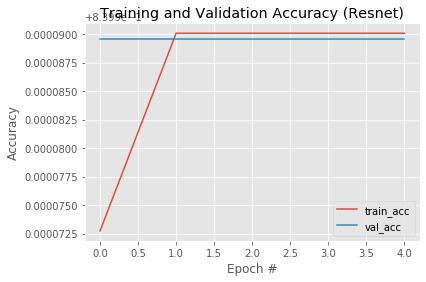

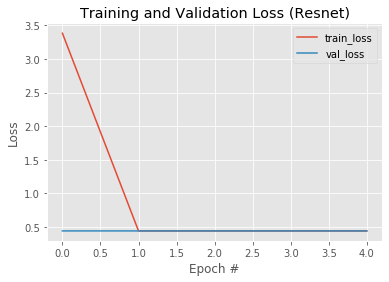

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制结果曲线

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_acc.png')
 
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_loss.png')

# 4 计算结果

In [65]:
# 恢复数据
with open(f'{base_path}/temp/test.txt', 'rb') as f:
    test = pickle.load(f)

In [66]:
test.columns

Index(['day', 'freq', 'gender', 'hour', 'label', 'q_ans_count',
       'q_diff_qa_days_count', 'q_diff_qa_days_max', 'q_diff_qa_days_mean',
       'q_diff_qa_days_min',
       ...
       'uid_enc_count', 'qid_enc_count', 'gender_count', 'freq_count',
       'uf_c1_count', 'uf_c2_count', 'uf_c3_count', 'uf_c4_count',
       'uf_c5_count', 'wk'],
      dtype='object', length=224)

In [67]:
X_val.columns

Index(['freq', 'gender', 'hour', 'q_ans_count', 'q_diff_qa_days_count',
       'q_diff_qa_days_max', 'q_diff_qa_days_mean', 'q_diff_qa_days_min',
       'q_diff_qa_days_std', 'q_diff_qa_days_sum',
       ...
       'uid_enc_count', 'qid_enc_count', 'gender_count', 'freq_count',
       'uf_c1_count', 'uf_c2_count', 'uf_c3_count', 'uf_c4_count',
       'uf_c5_count', 'wk'],
      dtype='object', length=220)

## 4.1 LGBM结果

In [68]:
sub['label'] = model_lgb.predict_proba(test[feature_cols])[:, 1]

In [69]:
sub.to_csv('./storage/result.txt', index=None, header=None, sep='\t')

## 4.2 神经网络结果

In [37]:
res = model.predict(test[feature_cols], batch_size=BATCH_SIZE)
res

array([[0.51117074],
       [0.51117074],
       [0.51117074],
       ...,
       [0.5111708 ],
       [0.5111708 ],
       [0.5111708 ]], dtype=float32)

In [87]:
test[feature_cols]

,freq,freq_count,gender,gender_count,hour,q_ans_count,q_diff_qa_days_max,q_diff_qa_days_mean,q_diff_qa_days_sum,q_has_img_max,...,uf_c2_count,uf_c3,uf_c3_count,uf_c4,uf_c4_count,uf_c5,uf_c5_count,uid_enc,uid_enc_count,wk
0,6,0.325453,4,0.0000,9,NaN,NaN,NaN,NaN,NaN,...,0.439214,203,0.479449,1376,0.000038,3,0.346068,1752473,0.000000,6
1,2,0.726702,4,0.0000,22,NaN,NaN,NaN,NaN,NaN,...,0.439214,396,0.456703,521,0.008534,3,0.346068,767938,0.000000,1
2,6,0.325453,2,0.4874,15,NaN,NaN,NaN,NaN,NaN,...,0.439214,205,0.083870,445,0.007599,3,0.346068,1147981,0.000009,3
3,5,1.000000,3,1.0000,4,4.0,11.0,3.0,12.0,0.0,...,0.439214,188,0.114102,1038,0.001950,2,1.000000,1372679,0.000015,2
4,6,0.325453,2,0.4874,19,NaN,NaN,NaN,NaN,NaN,...,0.168475,336,0.137013,788,0.001688,3,0.346068,1,0.297591,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141678,6,0.325453,4,0.0000,20,NaN,NaN,NaN,NaN,NaN,...,0.168475,81,0.020067,760,0.434533,3,0.346068,504330,0.000000,5
1141679,3,0.118357,4,0.0000,21,NaN,NaN,NaN,NaN,NaN,...,0.439214,121,0.094249,760,0.434533,3,0.346068,1066119,0.000003,1
1141680,2,0.726702,4,0.0000,15,NaN,NaN,NaN,NaN,NaN,...,0.001308,313,0.056923,760,0.434533,3,0.346068,435862,0.000000,0
1141681,6,0.325453,4,0.0000,8,NaN,NaN,NaN,NaN,NaN,...,0.439214,8,0.442846,1375,0.031122,3,0.346068,1287652,0.000015,0
